# Project: Viral Tweets

In this project, I am going to use the K-Nearest Neighbor algorithm to predict whether a tweet will go viral. Before jumping into using the classifier, let's first consider the problem I am trying to solve. Which features of a tweet are most closely linked to its popularity? Maybe the number of hashtags or the number of links in the tweet strongly influences its popularity. Maybe its virality is dependent on how many followers the person has. Maybe it's something more subtle like the specific language used in the tweets.

Let's explore these options by looking at the data I have available to me. I've imported the dataset and printed the following information:

* The total number of tweets in the dataset.
* The columns, or features, of the dataset.
* The text of the first tweet in the dataset.

Some of these features are dictionaries. For example, the feature `"user"` is a dictionary. 

In [3]:
import pandas as pd

all_tweets = pd.read_json("random_tweets.json", lines=True)

print(len(all_tweets))
print(all_tweets.columns)
print(all_tweets.loc[0]['text'])

print(all_tweets.loc[0]["user"])
print(all_tweets.loc[0]["user"]["screen_name"])


11099
Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'lang', 'possibly_sensitive', 'quoted_status_id',
       'quoted_status_id_str', 'extended_entities', 'quoted_status',
       'withheld_in_countries'],
      dtype='object')
RT @KWWLStormTrack7: We are more than a month into summer but the days are getting shorter. The sunrise is about 25 minutes later on July 3…
{'id': 145388018, 'id_str': '145388018', 'name': 'Derek Wolkenhauer', 'screen_name': 'derekw221', 'location': 'Waterloo, Iowa', 'description': '', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 215, 'friends_cou

# Defining Viral Tweets

A K-Nearest Neighbor classifier is a supervised machine learning algorithm, and as a result, I need to have a dataset with tagged labels. For this specific example, I need a dataset where every tweet is marked as viral or not viral. Unfortunately, this isn't a feature of this dataset &mdash; I'll need to make it myself.

So how do we define a viral tweet? A good place to start is to look at the number of retweets the tweet has. This can be found using the feature `"retweet_count"`.

```py
all_tweets['is_viral'] = np.where(all_tweets['retweet_count'] > 5, 1, 0)
```

Instead of using `5` as the benchmark for a viral tweet, I am going to use the median number of retweets. 

In [8]:
import numpy as np

print(all_tweets["retweet_count"].median())
median = all_tweets["retweet_count"].median()

all_tweets['is_viral'] = np.where(all_tweets['retweet_count'] > median, 1, 0)

print(all_tweets['is_viral'].value_counts())

13.0
0    5562
1    5537
Name: is_viral, dtype: int64


# Making Features

Now that I've created a label for every tweet in the dataset, I can begin thinking about which features might determine whether a tweet is viral. I can create new columns in our dataset to represent these features. 

The first 3 features I am going to create are tweet length, followers count, and friends count. 

In [27]:
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis=1)
all_tweets['followers_count'] = all_tweets.apply(lambda tweet: tweet['user']['followers_count'], axis=1)
all_tweets['friends_count'] = all_tweets.apply(lambda tweet: tweet['user']['friends_count'], axis=1)



# Normalizing The Data

Now it is time to extract the columns I need for input into my model. 

It is also important to scale the data for my features to ensure all features are considered equally. 

In [17]:
from sklearn.preprocessing import scale

labels = all_tweets['is_viral']
data = all_tweets[['tweet_length', 'followers_count', 'friends_count']]
scaled_data = scale(data, axis=0)
print(scaled_data[0])

[ 0.6164054  -0.02878298 -0.14483305]


# Creating the Training Set and Test Set

In [18]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size=0.2, random_state=1)

# Using the Classifier

I will start with a k value of 5 and use .score() to understand thw accuracy. 

In [19]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_data, train_labels)
print(classifier.score(test_data, test_labels))

0.5882882882882883


#### Results
You can see from the above that with the current features and a k value of 5, the accuracy is just under 59%. 

# Choosing K

Now that I know the accuracy with a k value of 5, it is time to understand what the max accuracy I can get with the current features and changing the k value between 1 and 200. 

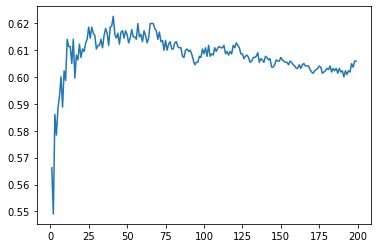

0.6225225225225225
41


In [22]:
import matplotlib.pyplot as plt

scores = []
max_score = 0
max_score_k = 0
for k in range(1, 200):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))
    if classifier.score(test_data, test_labels) > max_score:
        max_score = classifier.score(test_data, test_labels)
        max_score_k = k

plt.plot(range(1,200), scores)
plt.show()

print(max_score)
print(max_score_k)

#### Results

The above shows that maximum accuracy that can be achieved is around 62% with a k value of 41. 

# Exploring Using Other Data

### Adding Features Hashtag & Link Counts to Model

In [28]:
all_tweets['hashtag_count'] = all_tweets.apply(lambda tweet: tweet['text'].count('#'), axis=1)
all_tweets['link_count'] = all_tweets.apply(lambda tweet: tweet['text'].count('http'), axis=1)

In [29]:
labels = all_tweets['is_viral']
data = all_tweets[['tweet_length', 'followers_count', 'friends_count', 'hashtag_count', 'link_count']]
scaled_data = scale(data, axis=0)

In [30]:
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size=0.2, random_state=1)

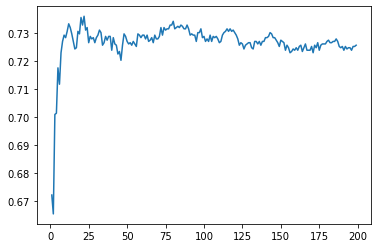

0.7360360360360361
22


In [31]:
scores = []
max_score = 0
max_score_k = 0
for k in range(1, 200):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))
    if classifier.score(test_data, test_labels) > max_score:
        max_score = classifier.score(test_data, test_labels)
        max_score_k = k

plt.plot(range(1,200), scores)
plt.show()

print(max_score)
print(max_score_k)

#### Results

By adding the additional features of hashtag count and link count the model accuracy improved to around 73.6% with a k value of 22. 